In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import networkx as nx
from scipy.sparse import lil_matrix, csr_matrix, vstack
import copy
import os
import helper
from wl import *
from joblib import Parallel, delayed
from time import time
import matplotlib.pyplot as plt
from glob import glob
import math
import pandas as pd
import collections
import sklearn
from sklearn import linear_model
import psutil
import pickle
import functools
from matplotlib import cm
from IPython.display import display
from sklearn import utils
import dataset_helper

In [3]:
def flatten(l, as_set = False):
    return functools.reduce(lambda acc, x: acc | set(x) if as_set else acc + list(x), l, set() if as_set else list())

## Retrieve graphs from Tobias' concept-graph extraction library

In [4]:
DATASET = 'ling-spam'
cache_file = dataset_helper.CACHE_PATH + '/dataset_graph_gml_{}-single.npy'.format(DATASET)
#cache_file = dataset_helper.CACHE_PATH + '/dataset_graph_cooccurrence_{}.npy'.format(DATASET)
X, Y = dataset_helper.get_dataset(DATASET, use_cached = True, cache_file = cache_file)
#X, Y = dataset_helper.get_subset_with_most_frequent_classes(X, Y, num_classes_to_keep = 3)
assert len(X) and len(Y), 'Dataset is empty: {}'.format(DATASET)
assert len(X) == len(Y)
graphs_per_topic = dataset_helper.get_dataset_dict(X, Y)
#graphs_per_topic = get_graphs(GRAPH_DIR, undirected = False, verbose = False, limit_elements = -1)

## Statistics about the graphs

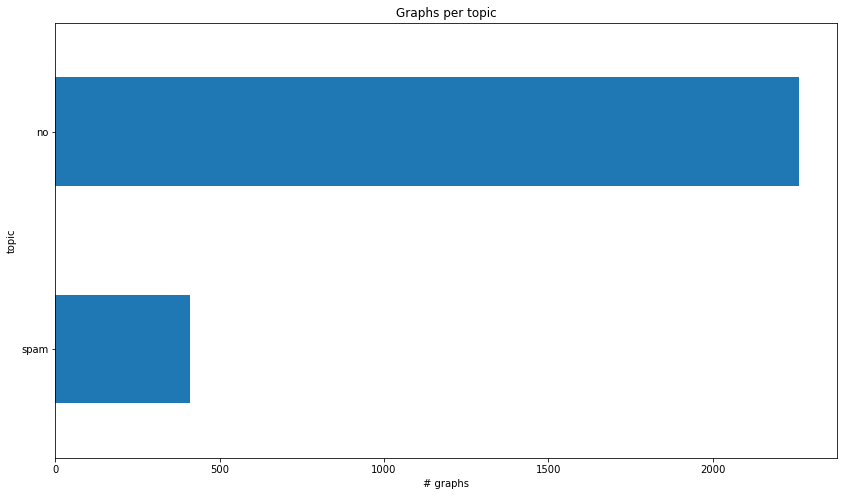

In [5]:
df_graphs_per_topic = pd.DataFrame([(topic, len(graphs), [len(x.nodes()) for x in graphs], [len(x.edges()) for x in graphs]) for topic, graphs in graphs_per_topic.items()], columns = ['topic', 'num_graphs', 'num_nodes', 'num_edges']).set_index(['topic']).sort_values(by = 'num_graphs')
ax = df_graphs_per_topic.plot.barh(title = 'Graphs per topic', legend = False, figsize = (14, 8))
ax.set_xlabel('# graphs')
plt.show()

def get_range_of(df, column):
    return df[column].apply(lambda x: min(x)).min(), df[column].apply(lambda x: max(x)).max()

nodes_range = get_range_of(df_graphs_per_topic, 'num_nodes')
edges_range = get_range_of(df_graphs_per_topic, 'num_edges')

if False:
    num_classes = len(set(Y))
    ncols, nrows = (2, max(2, math.ceil(num_classes / 2)))
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize = (14, 20))
    fig_, axes_ = plt.subplots(ncols=ncols, nrows=nrows, figsize = (14, 20))
    for idx, (topic, (num_graphs, num_nodes, num_edges)) in enumerate(df_graphs_per_topic.iterrows()):
        row = int(idx / ncols)
        col = idx % ncols
        print(row, col)
        ax = axes[row][col]
        ax_ = axes_[row][col]

        # 
        ax.set_title("{}".format(topic))
        ax.set_xlabel('# nodes')
        ax.hist(num_nodes, bins=40, normed = True, range = nodes_range)

        #
        ax_.set_title("{}".format(topic))
        ax_.set_xlabel('# edges')
        ax_.hist(num_edges, bins=40, normed = True, range = edges_range)
    fig.tight_layout()
    fig_.tight_layout()
plt.show()

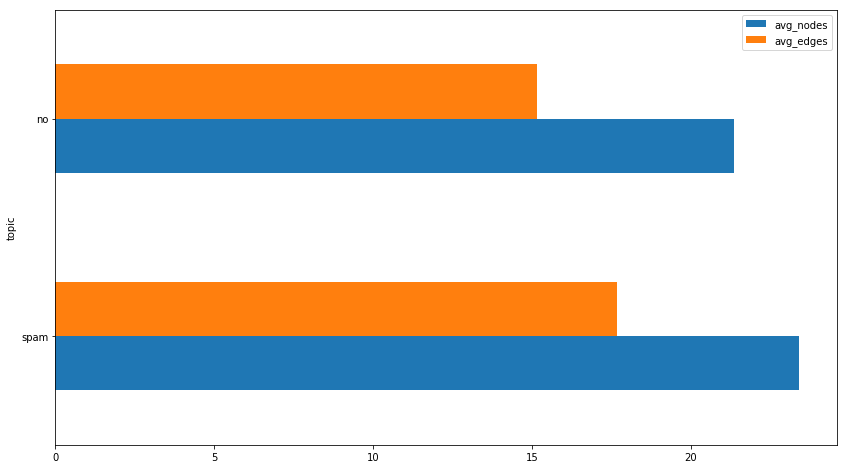

In [6]:
df_graphs_per_topic['avg_nodes'] = df_graphs_per_topic.num_nodes.apply(lambda x: np.mean(x))
df_graphs_per_topic['avg_edges'] = df_graphs_per_topic.num_edges.apply(lambda x: np.mean(x))
df_graphs_per_topic.plot(kind = 'barh', y = ['avg_nodes', 'avg_edges'], figsize = (14, 8))
plt.show()

## Filter categories

In [7]:
REMOVE_CATEGORIES = ['misc.forsale', 'comp.graphics']
REMOVE_CATEGORIES = []
graphs = graphs_per_topic.copy()
if len(REMOVE_CATEGORIES):
    for cat in REMOVE_CATEGORIES:
        del graphs[cat]

In [8]:
all_graphs = flatten(graphs.values())

In [9]:
all_nodes = set()
for g in all_graphs:
    all_nodes |= set(g.nodes())

In [10]:
print('#graphs:\t\t{}'.format(len(all_graphs)))
print('Unique tokens found:\t{}'.format(len(all_nodes)))

#graphs:		2674
Unique tokens found:	38598


## Create train/test split

In [11]:
# TODO: This should be done with dataset_helper.split_dataset(..)
def get_train_test_split(topic_graphs, train_split_ratio = 0.8):
    train = []
    test = []
    num_elements = {}
    for topic, graphs in topic_graphs.items():
        num_elements_train = int(len(graphs) * train_split_ratio)
        train += [(topic, x) for x in graphs[:num_elements_train]]
        test += [(topic, x) for x in graphs[num_elements_train:]]
    return train, test
train, test = get_train_test_split(graphs)

In [12]:
print('#graphs\n\ttrain:\t{}\n\ttest:\t{}'.format(len(train), len(test)))

#graphs
	train:	2139
	test:	535


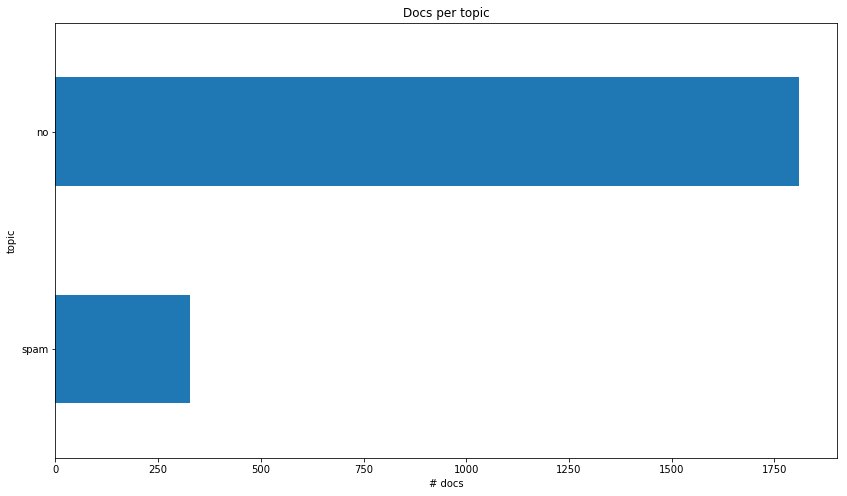

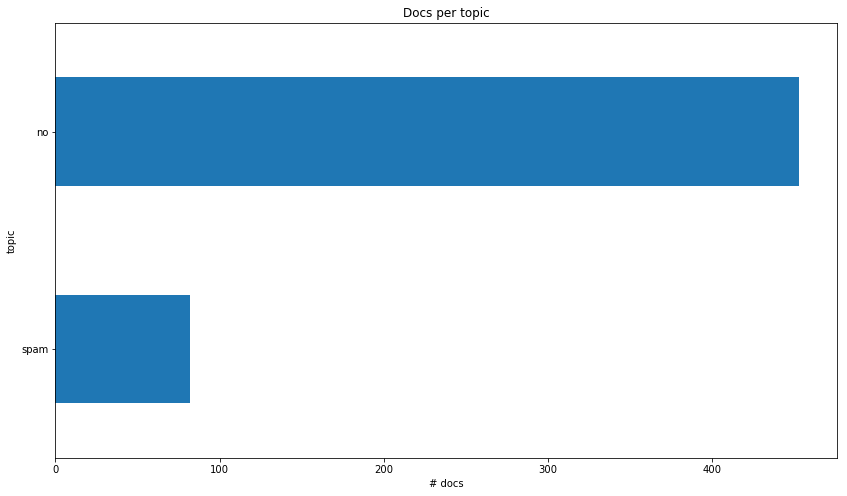

In [13]:
for set_ in [train, test]:
    X, Y = [x for label, x in set_], [label for label, x in set_]
    dataset_helper.plot_dataset_class_distribution(X, Y)
plt.show()

In [14]:
H = 2

## Calculate phi and gram-matrix of WL kernel for training instances

In [15]:
for set_ in [train, test]:
    for topic, graph in set_:
        if nx.number_of_edges(graph) == 0: set_.remove((topic, graph))

In [49]:
%%time
adjs = []
nodes = []
for topic, graph in train:
    sorted_nodes = sorted(graph.nodes())
    factor = nx.number_of_nodes(graph)
    adjs.append(nx.adjacency_matrix(graph, nodelist = sorted_nodes) / factor)
    nodes.append(sorted_nodes)
    
print('Calculating WL_train: start')
K_train, phi_list_train, label_lookup_train, label_counters_train = WL_compute(adjs, nodes, H, all_nodes = all_nodes, DEBUG = True, compute_k = False)
print('Calculating WL_train: end')

Calculating WL_train: start
Number of original labels 38598
K original is computed
Iteration 0: phi is computed
	Graph          0/2139
	Graph       1000/2139
	Graph       2000/2139
Number of compressed labels 41276
Itaration 0: phi computed
Iteration 1: phi is computed
	Graph          0/2139
	Graph       1000/2139
	Graph       2000/2139
Number of compressed labels 42236
Itaration 1: phi computed
Calculating WL_train: end
CPU times: user 51 s, sys: 460 ms, total: 51.5 s
Wall time: 51.6 s


### Train classifier with the phi s of the training instances

In [51]:
#sklearn.preprocessing.normalize(phi_list_train[-1], norm = 'l1', axis = 1, copy = False)

In [52]:
clf = sklearn.linear_model.Perceptron(n_iter = 500, verbose = False, n_jobs = -1, class_weight='balanced')
X = phi_list_train[-1].T
Y = [topic for topic, graphs in train]
clf.fit(X, Y)

Perceptron(alpha=0.0001, class_weight='balanced', eta0=1.0,
      fit_intercept=True, n_iter=500, n_jobs=-1, penalty=None,
      random_state=0, shuffle=True, verbose=False, warm_start=False)

## Get predictions for test instances

### Calculate phi for each test instance

In [39]:
%%time
def get_prediction(topic, graph):
    phi = compute_phi(graph, phi_list_train[0].shape, label_lookup_train, label_counters_train, h = H)[-1]
    return phi
    return phi / phi.sum()

USED_SET = test
PARALLEL_PREDICTION_JOBS = 1
print('Starting prediction')

if PARALLEL_PREDICTION_JOBS > 1:
    phi_test = Parallel(n_jobs=PARALLEL_PREDICTION_JOBS)(delayed(get_prediction)(*d) for d in list(USED_SET))
else:
    phi_test = [get_prediction(*d) for d in USED_SET]

Starting prediction
CPU times: user 11.4 s, sys: 299 ms, total: 11.7 s
Wall time: 11.7 s


In [40]:
nodes_nums = sum([nx.number_of_nodes(graph) for topic, graph in train])
nodes_nums

46706

### Predict test instances

In [53]:
%%time
def calculate_batches(l, fn, num_batches = 10, print_every = 5):
    elements = []
    num_elements_per_batch = math.ceil(len(l) / num_batches)
    print('Starting: #elements: {}, #batches: {}, #elements per Batch: {}'.format(len(l), num_batches, num_elements_per_batch))
    for idx in range(num_batches):
        start = idx * num_elements_per_batch
        end = min(len(l), start + num_elements_per_batch)
        if idx % print_every == 0: print('\tIteration: {:>4}/{}'.format(idx, num_batches))
        if end - start <= 0:
            break
        elements += fn(l[start:end]).tolist()
    return elements
predicted = calculate_batches(phi_test, clf.predict)

Starting: #elements: 535, #batches: 10, #elements per Batch: 54
	Iteration:    0/10
	Iteration:    5/10
CPU times: user 156 ms, sys: 80.3 ms, total: 236 ms
Wall time: 233 ms


### Metrics

In [55]:
Y_real = [topic for topic,graph in USED_SET]
Y_pred = predicted

#### About sparsity of test phi

In [56]:
df_phi_test_non_zero_elements = pd.DataFrame(list(zip(Y_real, Y_pred, [np.count_nonzero(x) for x in phi_test])), columns = ['real_topic', 'pred_topic', 'num_phi_non_zero'])

In [57]:
display(df_phi_test_non_zero_elements.groupby(by = 'real_topic').describe())
display(df_phi_test_non_zero_elements.groupby(by = 'pred_topic').describe())

num_phi_non_zero                                                  
                      count      mean        std  min  25%  50%    75%    max
real_topic                                                                   
no                    453.0  14.99117  20.768529  1.0  4.0  8.0  17.00  200.0
spam                   82.0  16.00000  25.892942  2.0  3.0  7.0  16.75  166.0

num_phi_non_zero                                                  
                      count       mean        std  min  25%  50%   75%    max
pred_topic                                                                   
no                    512.0  14.845703  21.010984  1.0  3.0  8.0  17.0  200.0
spam                   23.0  21.826087  32.107281  2.0  3.0  9.0  26.5  122.0

In [58]:
max_ = 0
vals_over_1 = 0
for i in phi_test:
    vals = i[i > 1]
    if not len(vals): continue
    vals_over_1 += 1
    m = max(vals)
    if m > max_:
        max_ = m
        print(max_)
print(vals_over_1)

0


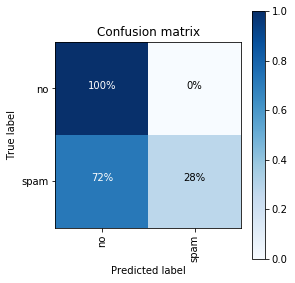

In [59]:
cf_mat = sklearn.metrics.confusion_matrix(Y_real, Y_pred)
classes = min(len(set(Y_real)) * 2, 30)
fig = plt.figure(figsize=(classes, classes))
helper.plot_confusion_matrix(cf_mat, clf.classes_, normalize = True)
plt.show()

In [60]:
sklearn.metrics.f1_score(Y_real, Y_pred, average='macro')

0.68847767086109057